In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from builtins import range
from sklearn.metrics import roc_auc_score
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram
from global_config import *


Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [3]:
def model_multi_kernel_shape(n_out, input_shape, out_activation='softmax'):
    """

    Symbolic summary:
    > c2' - p2 - c2 - p2 - c2 - p2 - c2 - p3 - d1
    where c2' -> multiple kernel shapes

    Parameters
    ----------
        n_out: integer, number of output nodes
        input_shape: tuple, an input shape, which doesn't include batch-axis.
        out_activation: activation function on the output
    """
    audio_input = Input(shape=input_shape)

    x = Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, return_decibel_melgram=True)(audio_input)
    x = BatchNormalization(axis=channel_axis)(x)

    x1 = Conv2D(7, (20, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x2 = Conv2D(7, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x3 = Conv2D(7, (3, 20), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    x = Concatenate(axis=channel_axis)([x1, x2, x3])

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(n_out, activation=out_activation, kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    model = Model(audio_input, out)

    return model

In [4]:
dataset_name = 'pedal-times_test.npz'
model_name = 'multi_kernel'

segment_exp_name = 'small-segment_{}'.format(model_name)
onset_exp_name = 'small-onset_{}'.format(model_name)
reg_w = 1e-4
batch_size = 1

print("-" * 60)
print("Beici: Welcome! Lets do something deep with {}.".format(dataset_name))
print("       We're gonna use {} model.".format(model_name))
npz_path = os.path.join(DIR_PEDAL_METADATA, dataset_name)
tracks = np.load(npz_path)
filenames = tracks['filename']

print("Beici: Getting model...")
onset_model = model_multi_kernel_shape(n_out=2,input_shape=ONSET_INPUT_SHAPE)
onset_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
segment_model = model_multi_kernel_shape(n_out=2,input_shape=SEGMENT_INPUT_SHAPE)
segment_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print("       Loading the best weights...")
onset_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(onset_exp_name)))
segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(segment_exp_name)))

------------------------------------------------------------
Beici: Welcome! Lets do something deep with pedal-times_test.npz.
       We're gonna use multi_kernel model.
Beici: Getting model...
       Loading the best weights...


In [39]:
def data_gen(audio_data, n_detect, nsp_excerpt, type_excerpt):
    """Data generator.
    excerpt: data of one audio file.
    n_detect: number of excerpts to be detected.
    nsp_detect: number of samples in one excerpt.
    """
    
    tile_times = int(np.ceil(NSP_SRC/nsp_excerpt))

    while True:
        for i in range(n_detect):
            
            if type_excerpt == 'onset':
                src_batch = np.array([audio_data[int(i*HOP_LENGTH):int(i*HOP_LENGTH+nsp_excerpt)]], dtype=K.floatx())
            elif type_excerpt == 'segment':
                src_batch = np.array([np.tile(audio_data[int(i*HOP_LENGTH):int(i*HOP_LENGTH+nsp_excerpt)],tile_times)[:NSP_SRC]],
                                     dtype=K.floatx())
                
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible
            
            yield src_batch

In [41]:
# for idx, filename in enumerate(filenames):
filename = filenames[0]    
paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
paudio, sr = librosa.load(paudio_path, sr=SR)  

len_onset_shape = int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER))
n_onset = int(np.ceil((len(paudio)-len_onset_shape)/HOP_LENGTH))
len_segment_shape = int(SR * MIN_SRC)
n_segment = int(np.ceil((len(paudio)-len_segment_shape)/HOP_LENGTH))

gen_onset = data_gen(paudio, n_onset, len_onset_shape, 'onset')
gen_segment = data_gen(paudio, n_segment, len_segment_shape, 'segment')

print("       Predicting...")
pred_onset = onset_model.predict_generator(gen_onset, n_onset // batch_size)
pred_segment = segment_model.predict_generator(gen_segment, n_segment // batch_size)


       Predicting...


In [165]:
pred_onset_filter = medfilt(pred_onset[:,1],15)
pred_segment_filter = medfilt(pred_segment[:,1],15)
longseg_idx = np.where((np.array(tracks['pedal_offset'][0])-np.array(tracks['pedal_onset'][0]))>0.3)[0]

frmtime_onset = np.arange(n_onset)*0.01+TRIM_SECOND_BEFORE
frmtime_segment = np.arange(n_segment)*0.01+MIN_SRC/2

(15, 25)

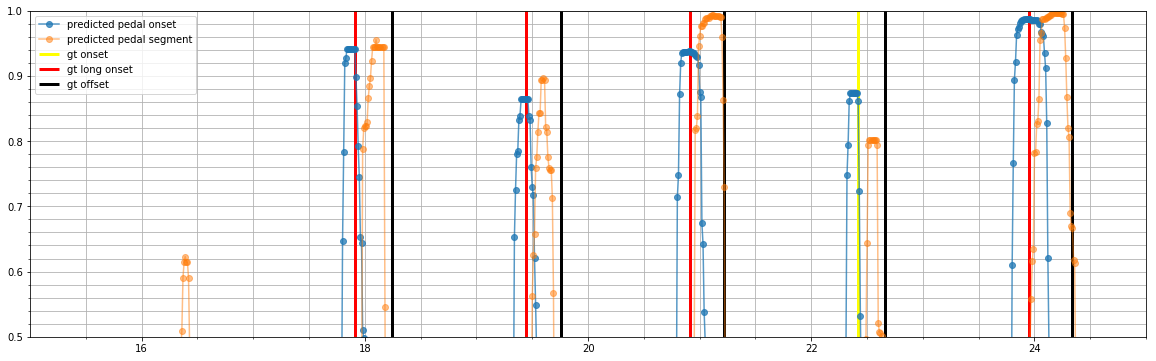

In [184]:
plt.figure(figsize=(20,6))
axes = plt.gca()
ymin, ymax = axes.get_ylim()
plt.vlines(np.array(tracks['pedal_onset'][0]), ymin, ymax, label='gt onset', color='yellow', lw=3)
plt.vlines(np.array(tracks['pedal_onset'][0])[longseg_idx], ymin, ymax, label='gt long onset', color='red', lw=3)
plt.vlines(np.array(tracks['pedal_offset'][0]), ymin, ymax, label='gt offset', color='black', lw=3)
plt.plot(frmtime_onset, pred_onset_filter, '-o', label='predicted pedal onset', alpha=0.75)
plt.plot(frmtime_segment, pred_segment_filter, '-o', label='predicted pedal segment', alpha=0.5)
plt.legend()
plt.ylim([0.5,1])

plt.grid(True)
axes.minorticks_on()
axes.grid(which='minor')

plt.xlim([15,25])

In [155]:
np.array(tracks['pedal_onset'][0])[longseg_idx]

array([  17.91397781,   19.44041859,   20.91344062,   23.95430297,
         49.57660641,   50.98953234,   79.35622406,   93.51352828,
        108.63103453,  139.94644125,  143.19430125,  151.50759422,
        152.19268969,  153.76854281,  157.74556875,  164.06233594,
        165.04257   ,  166.6665    ,  168.94347422,  170.80378219,
        171.98433656,  172.68545766,  178.46803734,  194.42822438,
        196.02143859,  197.72416125,  203.80187953,  209.88093328,
        212.56389   ,  216.92152453,  218.26634156,  218.93941781,
        220.01847656,  221.16697969,  222.42499125])